In [1]:
# Авторизация гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Здесь укажите путь к папке с ноутбуком и датасетом на гугл диске
%cd  /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Загрузка датасета
credit_data = pd.read_csv('./data_1_in.csv')
credit_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
credit_data.shape

(1048575, 3)

# Обработка таблицы с платежеспособностью

> Описание полей таблицы:
* ID - Идентификатор клиента	
* MONTHS_BALANCE - Номер месяца жизни договора, отсчитывается от текущего: 0 - текущий, -1 предыдущий и т.д. 
* STATUS - Статус договора:
> * 0: 1-29 дней в просрочке
> * 1: 30-59 дней в просрочке  
> * 2: 60-89 дней в просрочке  
> * 3: 90-119 дней в просрочке  
> * 4: 120-149 дней в просрочке  
> * 5: Просрочка 150 и более дней  
> * C: совершен платеж в отчетном месяце 
> * X: в отчетном месяце нет кредитного договора

> Стоит отметить, что в данной задаче у одного клиента может быть только один кредитный договор, если у клиента несколько кредитных договоров, то необходимо проводить их агрегацию с точки зрения просрочки. Чаще всего из текущих просрочек по всем действующим договорам выбирается максимальная просрочка.

Дополним таблицу с платежами столбцами с числовым статусом кредитного договора и флагом дефолта.

In [6]:
max_days_delay = 3

dict_status = {'X' : -2,
               'C' : -1,
               '0' : 0,
               '1' : 1,
               '2' : 2,
               '3' : 3,
               '4' : 4,
               '5' : 5
              }
credit_data['STATUS_NUM'] = credit_data['STATUS'].apply(lambda x: dict_status[x])
credit_data['CUR_DEFAULT'] = credit_data['STATUS_NUM'].apply(lambda x: int(x >= max_days_delay))

In [7]:
# наша стартовая таблица
credit_data.head()

,ID,MONTHS_BALANCE,STATUS,STATUS_NUM,CUR_DEFAULT
0,5001711,0,X,-2,0
1,5001711,-1,0,0,0
2,5001711,-2,0,0,0
3,5001711,-3,0,0,0
4,5001712,0,C,-1,0


In [8]:
credit_data.shape

(1048575, 5)

# Task 1. Построение винтажного анализа.

Винтажный анализ позволяет отслеживать состояние кредитного портфеля по поколениям выдач. Поколение можно выделить временными ограничениями (к примеру, одно поколение - все выдачи одного месяца) или причинными эпохами (к примеру, выдачи после внедрения изменений в процесс кредитования или выдачи в кризисный период).

В нашем примере поколения будем выделать помесячно.

Задание
Напишите функцию, которая сформирует DataFrame со следующим набором полей:
*  ID - уникальный номер клиента
*  MONTHS_BALANCE - текущий месяц
*  STATUS - статус платежа клиента в текущем месяце
*  STATUS_NUM - статус платежа в числовой шкале
*  CUR_DEFAULT - флаг нахождения клиента в дефолте на истории.

Алгоритм формирования поля CUR_DEFAULT:
*  Если клиент хотя бы раз уходил в дефолт, то флаг для месяца дефолта и всех последующих месяцев принимает значение 1, включая известную историю (0 исходной таблицы меняется на 1 для всех месяцев после первого дефолта);
* Если клиент ни разу не уходил в дефолт, то флаг принимает значение 0 для всех месяцев, по которым нам известна история и последующих;
* Для месяцев, когда нам неизвестна информация о клиенте, флаг принимает значение NaN (Прошлое для всех клиентов не заполняем)

При формировании таблицы следует учесть следующее:

* В датафрейме по сделке должны храниться записи по всем месяцам, начиная от месяца, задаваемого параметром функции, до текущего. Стоит отметить, что в таблице credit_data необязательно есть информация по требуемым месяцам;
* Для строк с 'дополненными' месяцами поля STATUS и STATUS_NUM должны принимать значение NaN

Требуемая таблица формируется функцией.
На вход функция принимает:
* Таблицу со статусами платежей по клиентам (credit_data)
* Ранжированный нумерной список месяцев, для которых необходимо собрать данные


In [11]:
from itertools import product


def make_vintage_table(input_data, time_list):
  res = pd.DataFrame(product(pd.Series(input_data.ID.unique()), pd.Series(time_list)), columns=['ID', 'MONTHS_BALANCE'])
  res['STATUS'] = np.nan
  res['STATUS_NUM'] = np.nan
  res['CUR_DEFAULT'] = np.nan

  id_month_input = input_data['MONTHS_BALANCE'].astype(str) + ' ' + input_data['ID'].astype(str)
  id_month_output = res['MONTHS_BALANCE'].astype(str) + ' ' + res['ID'].astype(str)
  res.loc[id_month_output.isin(id_month_input), 'STATUS'] = list(input_data['STATUS'])
  res.loc[id_month_output.isin(id_month_input), 'STATUS_NUM'] = list(input_data['STATUS_NUM'])

  first_status = input_data.loc[input_data['STATUS_NUM'].notnull()].groupby('ID')['MONTHS_BALANCE'].min()
  res['CUR_DEFAULT'] = res.apply(lambda row: 0 if row['MONTHS_BALANCE'] >= first_status[row['ID']] else np.nan, axis=1)

  first_default = pd.DataFrame(index=pd.Series(input_data.ID.unique()))
  first_default['default'] = 1
  id = pd.Series(input_data.ID.unique())
  id_default = id.isin(pd.Series((input_data.loc[input_data['CUR_DEFAULT'] == 1]).ID.unique()))
  first_default.loc[id[id_default], 'default'] = input_data.loc[input_data['CUR_DEFAULT'] == 1].groupby('ID')['MONTHS_BALANCE'].min()
  first_default[first_default.default != 1]
  res['CUR_DEFAULT'] = res.apply(lambda row: 1 if row['MONTHS_BALANCE'] >= first_default.loc[row['ID'], 'default'] else row['CUR_DEFAULT'], axis=1)
  return res

In [12]:
credit_data_vin = make_vintage_table(input_data=credit_data.copy(), time_list=range(0, -61, -1))

assert credit_data_vin.shape == (2805085, 5)
assert set(credit_data_vin.columns) == {'CUR_DEFAULT','ID','MONTHS_BALANCE','STATUS','STATUS_NUM'}
assert credit_data_vin['MONTHS_BALANCE'].sum() == -84152550
assert credit_data_vin['STATUS_NUM'].sum() == -837348
assert credit_data_vin[credit_data_vin['CUR_DEFAULT'].isna()].shape == (1543556, 5)

Используя таблицу для винтажного анализа, отобразим винтажи для временных срезов: -40, -45, -50, -55

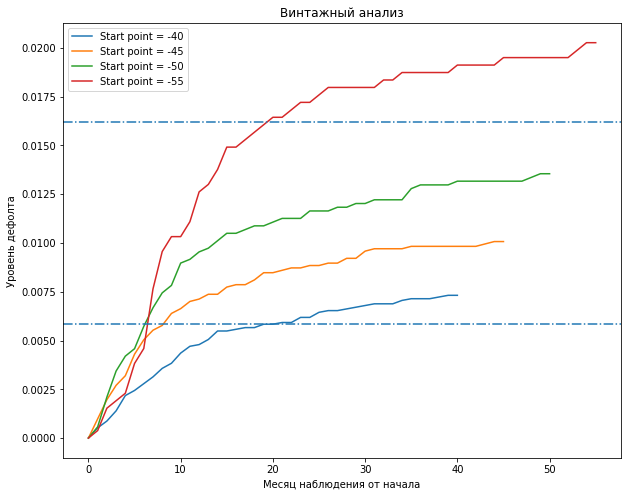

In [ ]:
start_month = -60

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Винтажный анализ')

def_rate_list = []
for start_month in range(-40, -60, -5):
    start_id = credit_data_vin[(credit_data_vin['CUR_DEFAULT']==0) & (credit_data_vin['MONTHS_BALANCE']==start_month)]['ID'].drop_duplicates()
    temp_df = credit_data_vin[(credit_data_vin['ID'].isin(start_id))&(credit_data_vin['MONTHS_BALANCE']>=start_month)].groupby('MONTHS_BALANCE')['CUR_DEFAULT'].agg(['mean', 'sum']).rename(columns={'mean' : 'DEFAULT_RATE', 'sum' : 'QNT_DEFAULTES'}).reset_index()
    plt.plot(range(temp_df.shape[0]), temp_df['DEFAULT_RATE'], label=f'Start point = {start_month}')
    def_rate_list.append(max(temp_df['QNT_DEFAULTES'])*0.8/len(start_id))
    
plt.axhline(max(def_rate_list), ls='-.')
plt.axhline(min(def_rate_list), ls='-.')
plt.xlabel('Месяц наблюдения от начала')
plt.ylabel('Уровень дефолта')
plt.legend()
plt.show()

> На графике пунктирными линиями отделены диапазоны, в которых находятся 80% всех дефолтов (для соотвествующего поколения).

> Начиная с определенного месяца наблюдения винтажи выходят на плато. Исходя из этих соображений, в качестве горизонта наблюдения, в данном случае, может быть выбран горизонт равный 15 месяцам.

In [ ]:
# credit_data_vin[credit_data_vin['ID']==5149192].head(60)

In [ ]:
# credit_data_vin[credit_data_vin['ID']==5150482].head(60)

# Task 2. Формирование витрины целевого события.

> Напишите функцию, которая на основе данных о платежах клиентов, сформирует таблицу с целевым событием для каждого платежа клиента на выбранном горизонте.

> Горизонт наблюдения - кол-во месяцев, начиная с рассматриваемого, на протяжении которых мы отслеживаем факт дефолта по клиенту.

> Целевым событием называется факт выхода клиента в дефолт на рассматриваемом горизонте.

> При формировании таблицы целевое событие определяется для каждой записи за исключением:
* Месяцев, первого дефолта и последующих (Наблюдений, которые уже побывали в дефолте хотя бы раз);
* Месяцев, для которых мы не можем собрать целевое событие (т.е. исключаем записи, для которых 'не набирается' горизонт события) 

> Описание функции:
* На вход принимает:
1. Таблицу со статусами платежей по клиентам (credit_data)
2. Длину горизонта наблюдения
* Возвращает pandas DataFrame со следующими столбцами:
1. ID - уникальный номер клиента	
2. MONTHS_BALANCE - текущий месяц
3. STATUS - статус платежа клиента в текущем месяце
4. STATUS_NUM - статус платежа в числовой шкале
5. CUR_DEFAULT - флаг нахождения клиента в дефолте в текущем месяце
6. DEFAULT - флаг вхождения клиента в дефолт на горизонте наблюдения


In [13]:
def make_target_table(input_data, horizon):
  # YOUR CODE HERE
    max_months = input_data.groupby('ID')['MONTHS_BALANCE'].max()
    min_months = input_data.groupby('ID')['MONTHS_BALANCE'].min()
    
    default_clients = set(input_data[input_data['CUR_DEFAULT'] == 1]['ID'])

    df = input_data.set_index(['ID', 'MONTHS_BALANCE'])
    df['DEFAULT'] = 0
    for client in default_clients:
        default_flag = False
        for month in range(min_months[client], max_months[client]+1):
            if default_flag:
                df.loc[(client, month), 'DEFAULT'] = np.nan
                continue
                
            if df.loc[(client, month), 'CUR_DEFAULT'] == 1:
                default_flag = True
                df.loc[(client, month), 'DEFAULT'] = np.nan
                continue
            
            if month+horizon > max_months[client]:
                df.loc[(client, month), 'DEFAULT'] = np.nan
                continue 
                
            if 1 in [df.loc[(client, month+hor), 'CUR_DEFAULT'] for hor in range(1, horizon+1)]:
                df.loc[(client, month), 'DEFAULT'] = 1
                
    non_default_clients = set(input_data['ID']) - default_clients
    
    drop_idx = [(i,j) for i in non_default_clients 
                    for j in range(max(max_months[i]-horizon+1, min_months[i]), max_months[i]+1)]
    df.loc[drop_idx, 'DEFAULT'] = np.nan
    
    return df.dropna().reset_index()

In [14]:
credit_data_tar = make_target_table(input_data=credit_data.copy(), horizon=6)

assert credit_data_tar.shape == (780417, 6)
assert set(credit_data_tar.columns) == {'CUR_DEFAULT', 'DEFAULT', 'ID', 'MONTHS_BALANCE', 'STATUS', 'STATUS_NUM'}
assert credit_data_tar['MONTHS_BALANCE'].sum() == -18124141
assert credit_data_tar['STATUS_NUM'].sum() == -623532
assert credit_data_tar[credit_data_tar['CUR_DEFAULT'].isna()].shape == (0, 6)
assert credit_data_tar['CUR_DEFAULT'].sum() == 0
assert credit_data_tar['DEFAULT'].sum() == 1668

In [ ]:
# credit_data[credit_data['ID']==5150482].head(60)

In [ ]:
# credit_data[credit_data['ID']==5149838].head(60)

# Task 3. Проведение roll-rate анализа.

> Напишите функцию, которая на основе витрины реализованной в п.2, формирует таблицу с информацией о среднем уровне дефолта клиентов в разрезе бакетов просрочки (STATUS) и возрастной группы кредитного договора.

> Возрастная группа кредитного договора определяется месяцем жизни кредитного договора в разбивке на несколько бинов. К примеру, если в таблице-источнике по договору есть записи от -20 до -5 месяцев жизни, то каждая запись будет попадать в один из 2х бинов: [-20; -10), [-10; 0) соответсвенно.

> Рассмотрим пример расчета уровня дефолта в бакете просрочки '0' и возрастной группе [-10;0):
1. Отберем из таблицы источника все записи, у которых STATUS принимает значение '0' в возрастной группе [-10;0)
2. Уровень дефолта будет определяться как отношение кол-ва месяцев, когда клиенты были в дефолте к общему кол-ву месяцев из выборки выше.   

> Описание функции.

> На вход принимает:
1. Таблицу с целевым событием на горизонте (credit_data_tar)
2. Начало временного периода (start_date)
3. Конец временного периода (end_date)
4. Длина одного временного среза (period_length)

> Возвращает удобную для просмотра сводную таблицу в формате pandas DataFrame:
* где названия столбцов совпадают с уникальными значениями в поле STATUS, а для отображения уровня дефолта в разрезе возрастной группы добавляется столбец PERIOD.	
* столбец PERIOD - возрастная группа вида [a, b), где a - дата начала возрастной группы (включительно), b - конец возрастной группы (не включительно)
* на пересечении бакета просрочки и возрастной группы находится средний уровень дефолта

In [15]:
def make_rollrate_table(input_data, start_date, end_date, period_length):
  # YOUR CODE HERE
  full_length = end_date - start_date
  columns = list(input_data['STATUS'].unique()) + ['PERIOD']
  periods = []
  start = start_date
  while start < end_date:
      periods.append('[' + str(start) + ', ' + str(min(start + period_length, end_date)) + ')')
      start += period_length
  res = pd.DataFrame(columns=columns)
  res['PERIOD'] = periods
  start = start_date
  i = 0
  statuses = input_data['STATUS'].unique()
  while start < end_date:
      for status in statuses:
          all = input_data[(input_data['STATUS'] == status) & (input_data['MONTHS_BALANCE'] >= start) & (input_data['MONTHS_BALANCE'] < min(start + period_length, end_date))].shape[0]
          default = input_data[(input_data['STATUS'] == status) & (input_data['MONTHS_BALANCE'] >= start) & (input_data['MONTHS_BALANCE'] < min(start + period_length, end_date)) & (input_data['DEFAULT'] == 1)].shape[0]
          if all == 0:
              default_rate = 0
          else:
              default_rate = default / all
          res.loc[i, status] = default_rate
      i += 1
      start += period_length
  return res
  


In [17]:
roll_rate_data = make_rollrate_table(input_data=credit_data_tar.copy(), start_date=-60, end_date=0, period_length=12)
display(roll_rate_data)
assert roll_rate_data.shape == (5, 6)
assert set(roll_rate_data.columns) == {'0', '1', '2', 'C', 'PERIOD', 'X'}
assert round(roll_rate_data['0'].sum(), 5) == 0.01634
assert round(roll_rate_data['1'].sum(), 5) == 0.238
assert round(roll_rate_data['2'].sum(), 5) == 2.19876
assert round(roll_rate_data['C'].sum(), 5) == 0
assert round(roll_rate_data['X'].sum(), 5) == 0.00845
assert set(roll_rate_data['PERIOD']) == {'[-12, 0)', '[-24, -12)', '[-36, -24)', '[-48, -36)', '[-60, -48)'}

,C,0,X,1,2,PERIOD
0,0.0,0.00458,0.004722,0.071984,0.541667,"[-60, -48)"
1,0.0,0.004265,0.00162,0.054159,0.45625,"[-48, -36)"
2,0.0,0.002486,0.000577,0.050251,0.4,"[-36, -24)"
3,0.0,0.002233,0.000785,0.026415,0.362245,"[-24, -12)"
4,0.0,0.002779,0.000749,0.035192,0.438596,"[-12, 0)"


Визуализация полученных результатов roll-rate анализа

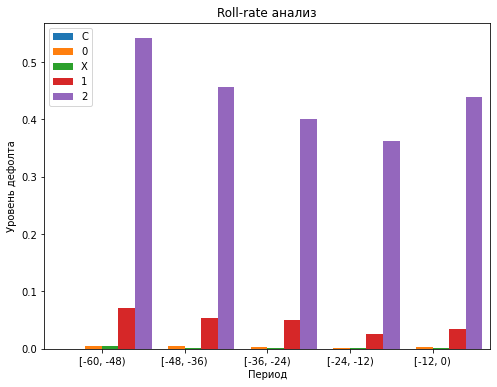

In [ ]:
ind = np.arange(len(roll_rate_data))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 6))
for i, col in enumerate(roll_rate_data.columns):
    if col != 'PERIOD':
        ax.bar(ind + i*width, roll_rate_data[col], width, label=col)        

ax.set(xticks=ind + 1.5*width, xticklabels=roll_rate_data['PERIOD'], xlim=[3*width - 1, len(roll_rate_data)])
ax.set_xlabel('Период')
ax.set_ylabel('Уровень дефолта')
ax.set_title('Roll-rate анализ')
ax.legend()

plt.show()

Результаты roll-rate анализа говорят нам, что для моделирования необходимо выделить два сегмента:
* клиенты, находящиеся в просрочке
* клиенты без текущей просрочки
уровень дефолта которых значимо различается и следует строить две отдельные модели для разных групп.

Данная сегментация производится, чтобы избежать следующей ситуации, когда некоторые атрибуты настолько сильно коррелируют с  целевой переменной, что вклад остальных практически нивелируется. Это приводит к моделям с плохим ранжированием внутри группы с одинаковым значением «главного» атрибута. Как мы сейчас увидели один из таких драйверов в кредитном риске – наличие или длительность просрочки по платежу. 

Чтобы показать разницу в сегментах полезно отобразить зависимость уровня дефолта от месяца для разных сегментов

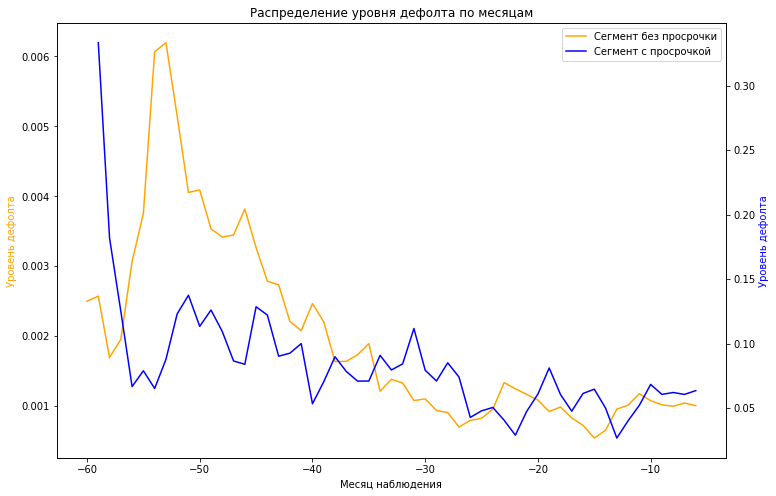

In [ ]:
segment_good = credit_data_tar[credit_data_tar['STATUS'].isin(['X', '0', 'C'])][['ID', 'MONTHS_BALANCE', 'DEFAULT']]
segment_bad = credit_data_tar[~credit_data_tar['STATUS'].isin(['X', '0', 'C'])][['ID', 'MONTHS_BALANCE', 'DEFAULT']]

segment_good_gr = segment_good.groupby('MONTHS_BALANCE')['DEFAULT'].mean().to_frame()
segment_bad_gr = segment_bad.groupby('MONTHS_BALANCE')['DEFAULT'].mean().to_frame()

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.set_title('Распределение уровня дефолта по месяцам')
ax1.set_xlabel('Месяц наблюдения')
ax1.set_ylabel('Уровень дефолта', color='orange')
line1, = ax1.plot(segment_good_gr.index, segment_good_gr['DEFAULT'], color='orange')

ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Уровень дефолта', color='blue')
line2, = ax2.plot(segment_bad_gr.index, segment_bad_gr['DEFAULT'], color='blue')

plt.legend((line1, line2), ('Сегмент без просрочки', 'Сегмент с просрочкой'))

plt.show()

# Заполните, пожалуйста, обратную связь по ДЗ
https://forms.gle/AY2Qadf1FBXArCuv7